# Coverage of genomic features *between* CTCF binding sites

In [1]:
import src
import pandas as pd
import numpy as np
import os

from pybedtools.bedtool import BedTool
from pybedtools import cleanup

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

figure_path = src.figures_path / "genome_coverage"
os.makedirs(figure_path, exist_ok=True)

cleanup()

In [2]:
ctcfs = pd.read_csv(src.interim_data_path / "ctcf_scores.tsv", sep="\t")
ctcfs.head()

,chr,start,end,orientation,ctcf_id,MotifScore,ChipSeqScore,rank_score_aggregate
0,chr1,237593,237953,>,0,9.790746,12.639115,1.502743e+09
1,chr1,521337,521697,>,1,10.259412,13.836791,1.680162e+09
2,chr1,714087,714447,>,2,9.893988,9.326291,1.342770e+09
3,chr1,805232,805362,>,3,14.365820,46.641218,3.446545e+09
4,chr1,839966,840326,>,4,16.393501,60.468042,3.756117e+09


In [3]:
gaps = pd.read_csv(src.external_data_path / "hg19_gaps.txt", sep="\t")
gaps.columns = src.coords + ['gap_type']
gaps = gaps.sort_values(src.coords).reset_index(drop=True)
gaps.head()

,chr,start,end,gap_type
0,chr1,0,10000,telomere
1,chr1,121535434,124535434,centromere
2,chr1,249240621,249250621,telomere
3,chr10,0,10000,telomere
4,chr10,39254935,42254935,centromere


In [4]:
hg19_total_length = 3101788170
chrY_length = 59373566
hg19_total_length_noY = hg19_total_length - chrY_length

def get_biplets(ctcfs):
    ctcf_ctcf = BedTool.from_dataframe(ctcfs)\
                   .closest(BedTool.from_dataframe(ctcfs), io=True, D='ref', d=True, fd=True)\
                   .to_dataframe(names=ctcfs.columns.map(lambda x: 'left_' + x).tolist() + 
                                       ctcfs.columns.map(lambda x: 'right_' + x).tolist() + ['distance'])
    ctcf_ctcf = ctcf_ctcf[ctcf_ctcf.left_end < ctcf_ctcf.right_start]
    biplets = pd.DataFrame({
        'chr': ctcf_ctcf.left_chr,
        'start': ctcf_ctcf.left_start,
        'end': ctcf_ctcf.right_end,
        'pattern': ctcf_ctcf.left_orientation + ctcf_ctcf.right_orientation
    })
    #removing gaps
    biplets = BedTool.from_dataframe(biplets).sort().subtract(BedTool.from_dataframe(gaps).sort(), A=True)\
                     .to_dataframe(names = biplets.columns)
    biplets['length'] = (biplets.end - biplets.start)
    biplets['genome_coverage'] = biplets['length'] / hg19_total_length_noY
    return biplets

In [5]:
quantiles = np.linspace(0,1,11)

## We compute all the biplets covering the entire genome, considering each lower bound quantile based on rank aggregated score

In [6]:
all_biplets = []

for q in src.progress(quantiles):
    filtered_ctcfs = ctcfs[ctcfs.rank_score_aggregate > ctcfs.rank_score_aggregate.quantile(q)]
    qbiplets = get_biplets(filtered_ctcfs)
    qbiplets['lower_bound_quantile'] = q
    all_biplets.append(qbiplets)
all_biplets = pd.concat(all_biplets, axis=0)

In [7]:
all_biplets.to_csv(src.interim_data_path / "all_biplets.tsv", sep="\t", index=False, header=True)

### Genome coverage

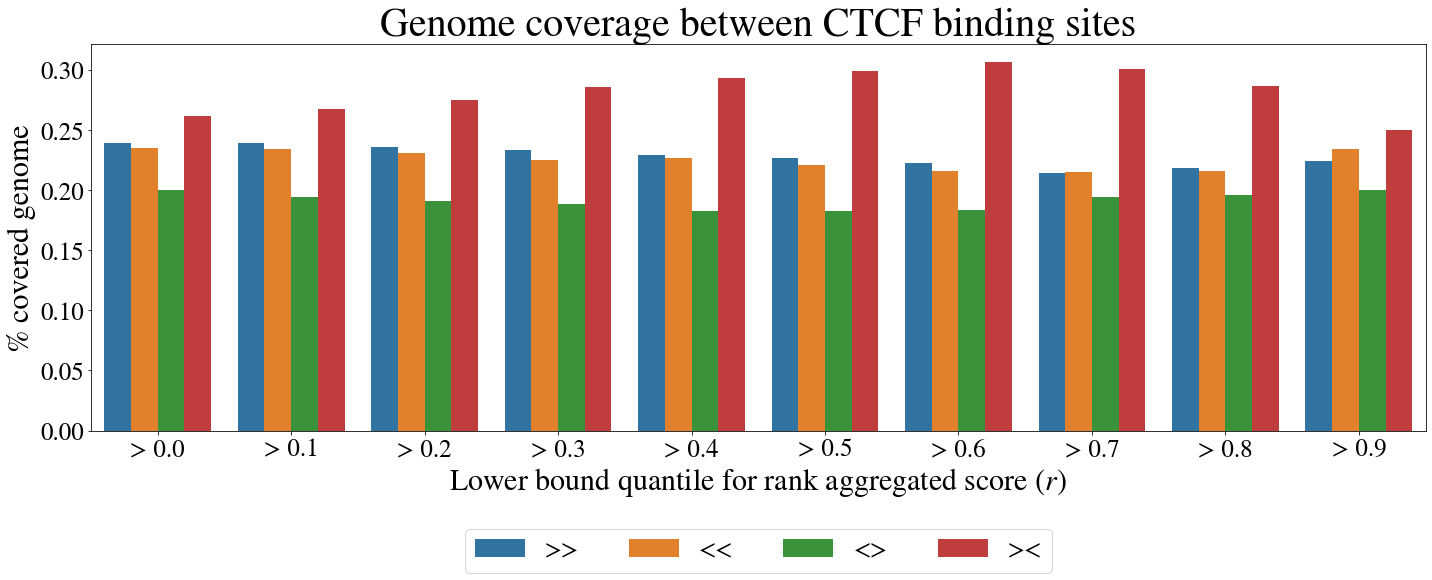

In [8]:
fig = plt.figure(figsize=(20, 8))
sns.barplot(data=all_biplets, x='lower_bound_quantile', y='genome_coverage', hue='pattern', estimator=sum, ci=None, hue_order=['>>', '<<', '<>', '><'])
plt.xticks(np.arange(len(quantiles) - 1), ["> {:.1f}".format(q) for q in quantiles[: -1]], fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel("Lower bound quantile for rank aggregated score ($r$)", fontsize=30)
plt.ylabel("% covered genome", fontsize=30)
plt.title("Genome coverage between CTCF binding sites", fontsize=40)
plt.legend(fontsize=25, ncol=4, loc='lower center', bbox_to_anchor=(0.5, -0.4))
fig.savefig(figure_path / "genome_coverage.pdf", bbox_inches='tight', transparent=True)
plt.show()

## Conserved boundaries coverage

In [9]:
window = 25000

consensus_boundaries = pd.read_csv(src.interim_data_path / "consensus_boundaries" / "consensus_boundaries_w{}.tsv".format(window), sep="\t")
consensus_boundaries['end'] += 1
consensus_boundaries.head()

,chr,start,end,boundary_uid,cell_type,n_cell_types,n_boundaries,Ery,MK,Mac0,Mon,nB,nCD4,nCD8,length,covered_genome
0,chr1,1612500,1612501,Mon_0000_start,Mon,1,1,0,0,0,1,0,0,0,1,3.223947e-10
1,chr1,1646875,1646876,nB_0000_start,nB,1,1,0,0,0,0,1,0,0,1,3.223947e-10
2,chr1,1842500,1847501,"nB_0000_end,Ery_0000_start,Mon_0000_end","Ery,nB,Mon",3,3,1,0,0,1,1,0,0,5001,1.612296e-06
3,chr1,2112500,2112501,"nB_0001_start,Mac0_0000_start","nB,Mac0",2,2,0,0,1,0,1,0,0,1,3.223947e-10
4,chr1,2342500,2350001,"nB_0001_end,Mac0_0000_end,Ery_0000_end,nB_0002...","nCD8,Ery,nB,Mac0",4,5,1,0,1,0,2,0,1,7501,2.418282e-06


In [10]:
consbond_biplets = BedTool.from_dataframe(consensus_boundaries)\
                            .intersect(BedTool.from_dataframe(all_biplets.sort_values(src.coords)), wo=True)\
                            .to_dataframe(names=consensus_boundaries.columns.tolist() + all_biplets.columns.tolist() + ['overlap'])
consbond_biplets.head()

/home/nanni/anaconda3/envs/hic_reconcile_ctcf/lib/python3.7/site-packages/pandas/io/parsers.py:702: UserWarning: Duplicate names specified. This will raise an error in the future.
  return _read(filepath_or_buffer, kwds)


,chr,start,end,boundary_uid,cell_type,n_cell_types,n_boundaries,Ery,MK,Mac0,...,length,covered_genome,chr.1,start.1,end.1,pattern,length.1,genome_coverage,lower_bound_quantile,overlap
0,chr1,1612500,1612501,Mon_0000_start,Mon,1,1,0,0,0,...,1,3.223947e-10,chr1,1597131,1656417,<<,59286,0.000019,0.5,1
1,chr1,1612500,1612501,Mon_0000_start,Mon,1,1,0,0,0,...,1,3.223947e-10,chr1,1597131,1656417,<<,59286,0.000019,0.6,1
2,chr1,1612500,1612501,Mon_0000_start,Mon,1,1,0,0,0,...,1,3.223947e-10,chr1,1610342,1656417,<<,46075,0.000015,0.0,1
3,chr1,1612500,1612501,Mon_0000_start,Mon,1,1,0,0,0,...,1,3.223947e-10,chr1,1610342,1656417,<<,46075,0.000015,0.1,1
4,chr1,1612500,1612501,Mon_0000_start,Mon,1,1,0,0,0,...,1,3.223947e-10,chr1,1610342,1656417,<<,46075,0.000015,0.2,1


In [11]:
minimum_conservation = 2

sel_consbond_bibplets = consbond_biplets[consbond_biplets.n_cell_types >= minimum_conservation].copy()
tot_sel_bounds_size = sel_consbond_bibplets.drop_duplicates(subset="boundary_uid").length.sum()
sel_consbond_bibplets['covered_boundaries'] = sel_consbond_bibplets.overlap / tot_sel_bounds_size
sel_consbond_bibplets.head()

,chr,start,end,boundary_uid,cell_type,n_cell_types,n_boundaries,Ery,MK,Mac0,...,covered_genome,chr.1,start.1,end.1,pattern,length.1,genome_coverage,lower_bound_quantile,overlap,covered_boundaries
20,chr1,1842500,1847501,"nB_0000_end,Ery_0000_start,Mon_0000_end","Ery,nB,Mon",3,3,1,0,0,...,0.000002,chr1,1840360,1850685,<<,10325,0.000003,0.0,5001,0.000033
21,chr1,1842500,1847501,"nB_0000_end,Ery_0000_start,Mon_0000_end","Ery,nB,Mon",3,3,1,0,0,...,0.000002,chr1,1840360,1850685,<<,10325,0.000003,0.1,5001,0.000033
22,chr1,1842500,1847501,"nB_0000_end,Ery_0000_start,Mon_0000_end","Ery,nB,Mon",3,3,1,0,0,...,0.000002,chr1,1840360,1850685,<<,10325,0.000003,0.2,5001,0.000033
23,chr1,1842500,1847501,"nB_0000_end,Ery_0000_start,Mon_0000_end","Ery,nB,Mon",3,3,1,0,0,...,0.000002,chr1,1840360,1850685,<<,10325,0.000003,0.3,5001,0.000033
24,chr1,1842500,1847501,"nB_0000_end,Ery_0000_start,Mon_0000_end","Ery,nB,Mon",3,3,1,0,0,...,0.000002,chr1,1840360,1875792,<>,35432,0.000012,0.4,5001,0.000033


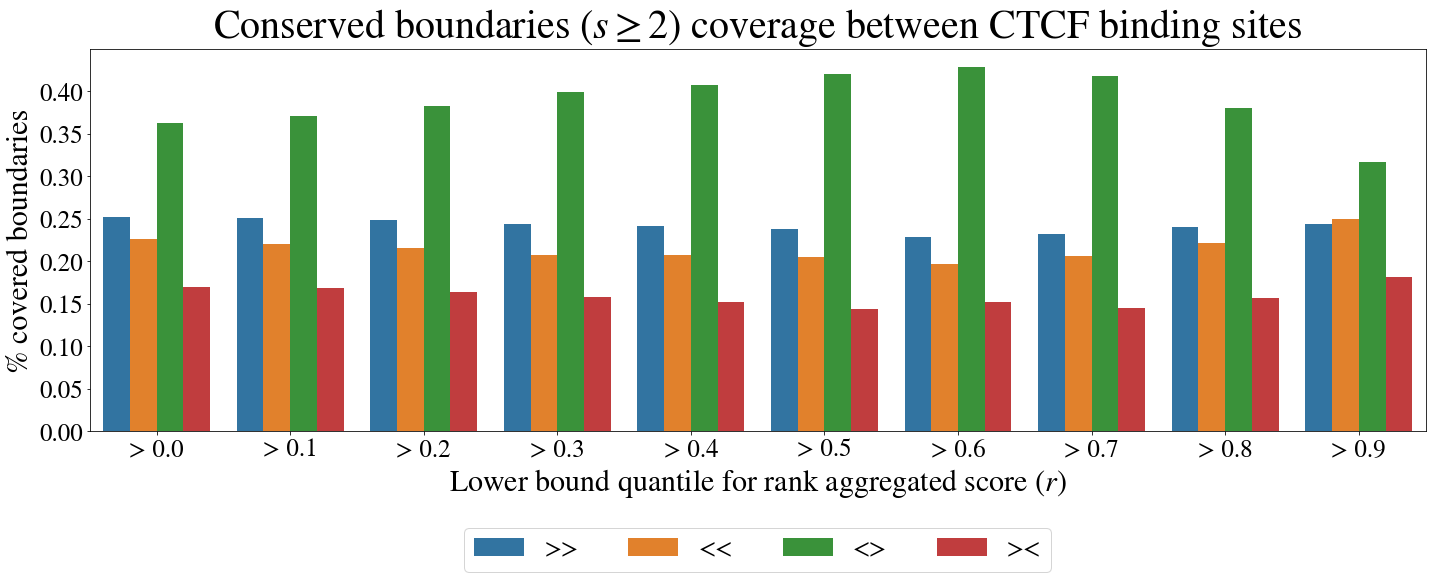

In [12]:
fig = plt.figure(figsize=(20, 8))
sns.barplot(data=sel_consbond_bibplets, x='lower_bound_quantile', y='covered_boundaries', hue='pattern', estimator=sum, ci=None, hue_order=['>>', '<<', '<>', '><'])
plt.xticks(np.arange(len(quantiles) - 1), ["> {:.1f}".format(q) for q in quantiles[: -1]], fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel("Lower bound quantile for rank aggregated score ($r$)", fontsize=30)
plt.ylabel("% covered boundaries", fontsize=30)
plt.title("Conserved boundaries ($s \geq {}$) coverage between CTCF binding sites".format(minimum_conservation), fontsize=40)
plt.legend(fontsize=25, ncol=4, loc='lower center', bbox_to_anchor=(0.5, -0.4))
fig.savefig(figure_path / "conserved_boundaries_min{}_coverage.pdf".format(minimum_conservation), bbox_inches='tight', transparent=True)
plt.show()

### Gene coverage

In [13]:
genes = pd.read_csv(src.processed_data_path / "gene_expression_MoMaTA_RNAseq.tsv", sep="\t")
genes['length'] = genes.end - genes.start
tot_gene_size = genes.length.sum()
genes.head()

,chr,start,end,gene,strand,TopPval,2ndPval,TopMod,2ndMod,mu_6122.gene,...,RPKM_bc28_D0_TA,RPKM_6124,RPKM_7165,RPKM_bc27_D6_DMSO,RPKM_bc28_D6_DMSO,RPKM_6123,RPKM_7164,RPKM_bc27_D6_TA,RPKM_bc28_D6_TA,length
0,chr1,11869,14412,DDX11L1,+,0.472094,0.314943,4.0,5.0,0.495946,...,0.181049,0.045055,0.118216,0.010562,0.062163,0.208764,0.046472,0.047394,0.334172,2543
1,chr1,14363,29806,WASH7P,-,0.390765,0.200777,1.0,4.0,1.853250,...,6.777173,4.313933,5.787671,4.241810,2.292184,4.454790,6.710947,4.661233,2.309895,15443
2,chr1,29554,31109,MIR1302-10,+,0.093727,0.078845,1.0,6.0,-7.653920,...,0.001436,0.000589,0.000605,0.001523,0.000879,0.000302,0.000582,0.000706,0.000809,1555
3,chr1,34554,36081,FAM138A,-,0.092136,0.076408,1.0,2.0,-8.069100,...,0.001411,0.000245,0.000455,0.002638,0.000377,0.001521,0.000473,0.000558,0.000526,1527
4,chr1,52473,54936,OR4G4P,+,0.075032,0.074100,1.0,3.0,-8.300660,...,0.000297,0.000289,0.000224,0.000717,0.000532,0.000265,0.000352,0.000301,0.000251,2463


In [14]:
genes_biplets = BedTool.from_dataframe(genes)\
                            .intersect(BedTool.from_dataframe(all_biplets.sort_values(src.coords)), wo=True)\
                            .to_dataframe(names=genes.columns.tolist() + all_biplets.columns.tolist() + ['overlap'])
genes_biplets['covered_genes'] = genes_biplets.overlap / tot_gene_size
genes_biplets.head()

/home/nanni/anaconda3/envs/hic_reconcile_ctcf/lib/python3.7/site-packages/pandas/io/parsers.py:702: UserWarning: Duplicate names specified. This will raise an error in the future.
  return _read(filepath_or_buffer, kwds)
/home/nanni/anaconda3/envs/hic_reconcile_ctcf/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3214: DtypeWarning: Columns (5,6,7,8,28,35,38) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


,chr,start,end,gene,strand,TopPval,2ndPval,TopMod,2ndMod,mu_6122.gene,...,length,chr.1,start.1,end.1,pattern,length.1,genome_coverage,lower_bound_quantile,overlap,covered_genes
0,chr1,227615,267253,AP006222.2,-,0.344798,0.146364,4,1,-0.081595,...,39638,chr1,237593,521697,>>,284104,0.000093,0.0,29660,0.000017
1,chr1,227615,267253,AP006222.2,-,0.344798,0.146364,4,1,-0.081595,...,39638,chr1,237593,521697,>>,284104,0.000093,0.1,29660,0.000017
2,chr1,227615,267253,AP006222.2,-,0.344798,0.146364,4,1,-0.081595,...,39638,chr1,237593,521697,>>,284104,0.000093,0.2,29660,0.000017
3,chr1,227615,267253,AP006222.2,-,0.344798,0.146364,4,1,-0.081595,...,39638,chr1,237593,521697,>>,284104,0.000093,0.3,29660,0.000017
4,chr1,227615,267253,AP006222.2,-,0.344798,0.146364,4,1,-0.081595,...,39638,chr1,237593,521697,>>,284104,0.000093,0.4,29660,0.000017


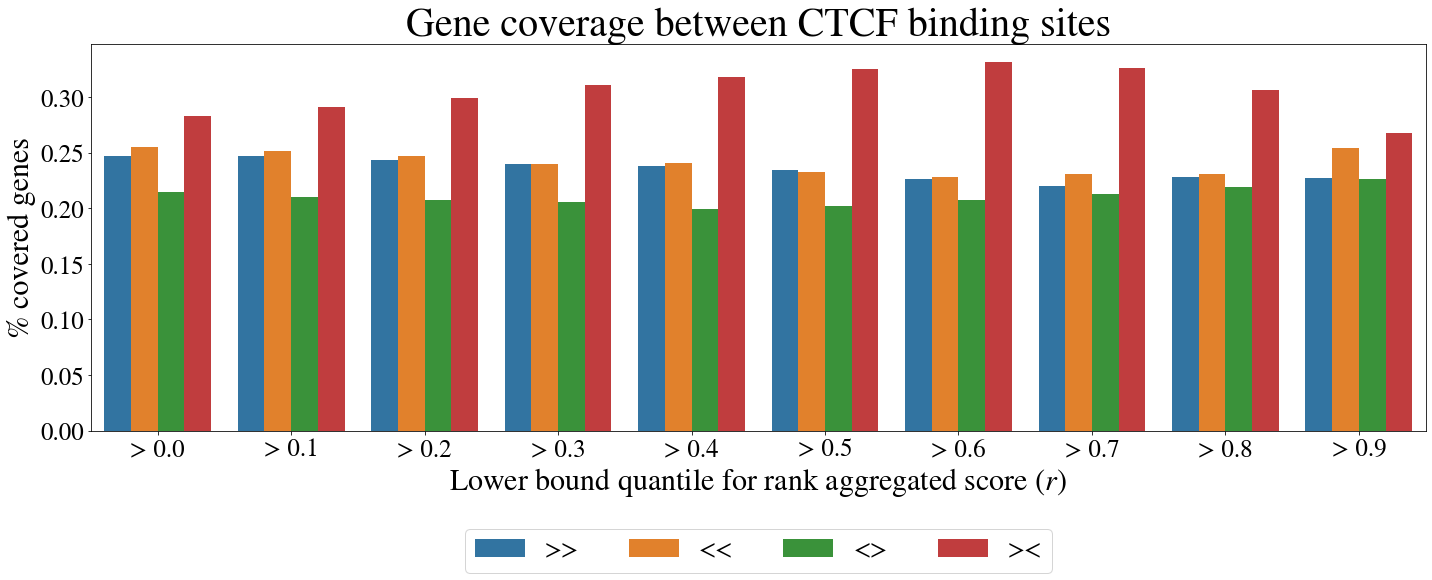

In [15]:
fig = plt.figure(figsize=(20, 8))
sns.barplot(data=genes_biplets, x='lower_bound_quantile', y='covered_genes', hue='pattern', estimator=sum, ci=None, hue_order=['>>', '<<', '<>', '><'])
plt.xticks(np.arange(len(quantiles) - 1), ["> {:.1f}".format(q) for q in quantiles[: -1]], fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel("Lower bound quantile for rank aggregated score ($r$)", fontsize=30)
plt.ylabel("% covered genes", fontsize=30)
plt.title("Gene coverage between CTCF binding sites".format(minimum_conservation), fontsize=40)
plt.legend(fontsize=25, ncol=4, loc='lower center', bbox_to_anchor=(0.5, -0.4))
fig.savefig(figure_path / "gene_coverage.pdf", bbox_inches='tight', transparent=True)
plt.show()

### TSS coverage

In [16]:
tss = pd.DataFrame({
    'chr': genes.chr,
    'start': genes.apply(lambda x: x.start if x.strand == "+" else x.end, axis=1),
    'end': 0,
    'gene': genes.gene,
    'gene_strand': genes.strand
})
tss['end'] = tss.start + 1
tot_tss_length = (tss.end - tss.start).sum()
tss.head()

,chr,start,end,gene,gene_strand
0,chr1,11869,11870,DDX11L1,+
1,chr1,29806,29807,WASH7P,-
2,chr1,29554,29555,MIR1302-10,+
3,chr1,36081,36082,FAM138A,-
4,chr1,52473,52474,OR4G4P,+


In [17]:
tss_biplets = BedTool.from_dataframe(tss)\
                            .intersect(BedTool.from_dataframe(all_biplets.sort_values(src.coords)), wo=True)\
                            .to_dataframe(names=tss.columns.tolist() + all_biplets.columns.tolist() + ['overlap'])
tss_biplets['covered_tss'] = tss_biplets.overlap / tot_tss_length
tss_biplets.head()

/home/nanni/anaconda3/envs/hic_reconcile_ctcf/lib/python3.7/site-packages/pandas/io/parsers.py:702: UserWarning: Duplicate names specified. This will raise an error in the future.
  return _read(filepath_or_buffer, kwds)


,chr,start,end,gene,gene_strand,chr.1,start.1,end.1,pattern,length,genome_coverage,lower_bound_quantile,overlap,covered_tss
0,chr1,267253,267254,AP006222.2,-,chr1,237593,521697,>>,284104,0.000093,0.0,1,0.000018
1,chr1,267253,267254,AP006222.2,-,chr1,237593,521697,>>,284104,0.000093,0.1,1,0.000018
2,chr1,267253,267254,AP006222.2,-,chr1,237593,521697,>>,284104,0.000093,0.2,1,0.000018
3,chr1,267253,267254,AP006222.2,-,chr1,237593,521697,>>,284104,0.000093,0.3,1,0.000018
4,chr1,267253,267254,AP006222.2,-,chr1,237593,521697,>>,284104,0.000093,0.4,1,0.000018


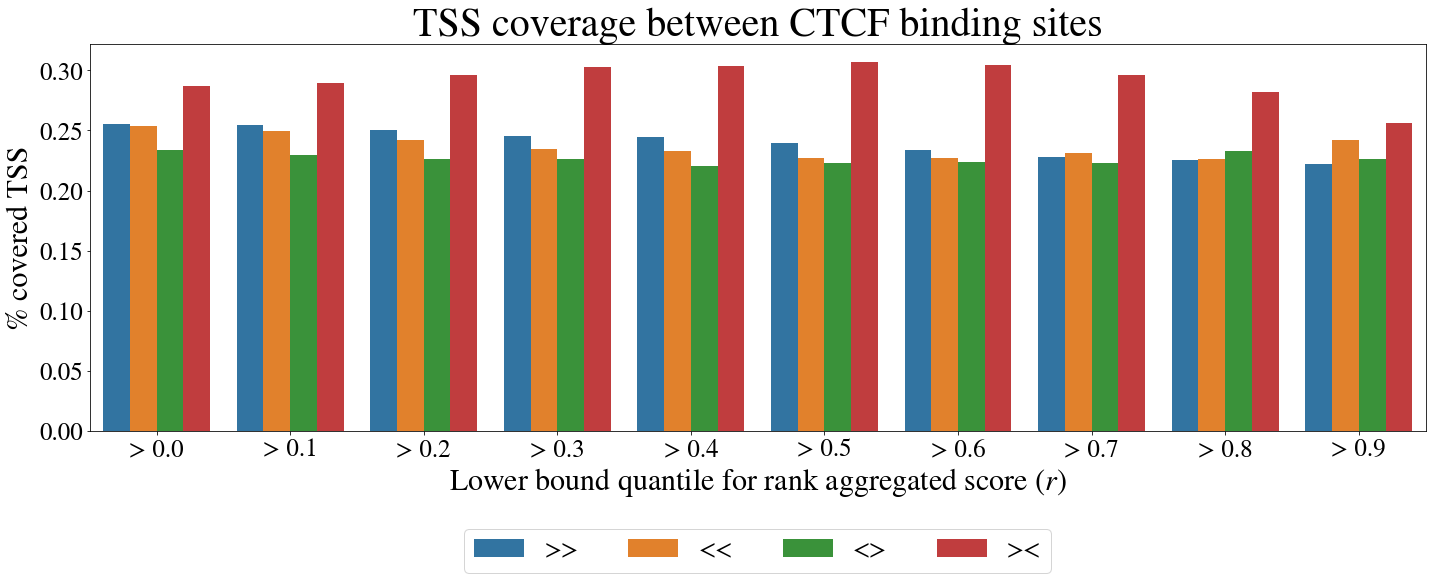

In [18]:
fig = plt.figure(figsize=(20, 8))
sns.barplot(data=tss_biplets, x='lower_bound_quantile', y='covered_tss', hue='pattern', estimator=sum, ci=None, hue_order=['>>', '<<', '<>', '><'])
plt.xticks(np.arange(len(quantiles) - 1), ["> {:.1f}".format(q) for q in quantiles[: -1]], fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel("Lower bound quantile for rank aggregated score ($r$)", fontsize=30)
plt.ylabel("% covered TSS", fontsize=30)
plt.title("TSS coverage between CTCF binding sites".format(minimum_conservation), fontsize=40)
plt.legend(fontsize=25, ncol=4, loc='lower center', bbox_to_anchor=(0.5, -0.4))
fig.savefig(figure_path / "gene_TSS_coverage.pdf", bbox_inches='tight', transparent=True)
plt.show()

### TTS coverage

In [19]:
tts = pd.DataFrame({
    'chr': genes.chr,
    'start': genes.apply(lambda x: x.end if x.strand == "+" else x.start, axis=1),
    'end': 0,
    'gene': genes.gene,
    'gene_strand': genes.strand
})
tts['end'] = tts.start + 1
tot_tts_length = (tts.end - tts.start).sum()
tts.head()

,chr,start,end,gene,gene_strand
0,chr1,14412,14413,DDX11L1,+
1,chr1,14363,14364,WASH7P,-
2,chr1,31109,31110,MIR1302-10,+
3,chr1,34554,34555,FAM138A,-
4,chr1,54936,54937,OR4G4P,+


In [20]:
tts_biplets = BedTool.from_dataframe(tts)\
                            .intersect(BedTool.from_dataframe(all_biplets.sort_values(src.coords)), wo=True)\
                            .to_dataframe(names=tts.columns.tolist() + all_biplets.columns.tolist() + ['overlap'])
tts_biplets['covered_tts'] = tts_biplets.overlap / tot_tts_length
tts_biplets.head()

/home/nanni/anaconda3/envs/hic_reconcile_ctcf/lib/python3.7/site-packages/pandas/io/parsers.py:702: UserWarning: Duplicate names specified. This will raise an error in the future.
  return _read(filepath_or_buffer, kwds)


,chr,start,end,gene,gene_strand,chr.1,start.1,end.1,pattern,length,genome_coverage,lower_bound_quantile,overlap,covered_tts
0,chr1,453948,453949,RP4-669L17.10,+,chr1,237593,521697,>>,284104,0.000093,0.0,1,0.000018
1,chr1,453948,453949,RP4-669L17.10,+,chr1,237593,521697,>>,284104,0.000093,0.1,1,0.000018
2,chr1,453948,453949,RP4-669L17.10,+,chr1,237593,521697,>>,284104,0.000093,0.2,1,0.000018
3,chr1,453948,453949,RP4-669L17.10,+,chr1,237593,521697,>>,284104,0.000093,0.3,1,0.000018
4,chr1,453948,453949,RP4-669L17.10,+,chr1,237593,521697,>>,284104,0.000093,0.4,1,0.000018


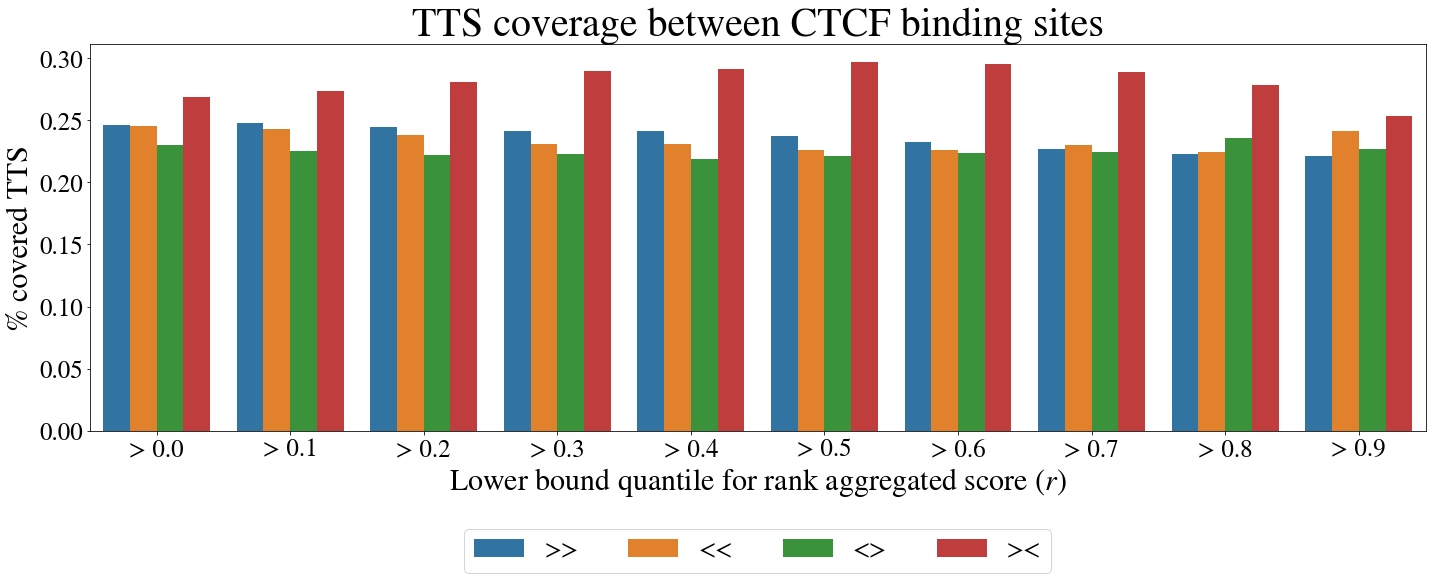

In [21]:
fig = plt.figure(figsize=(20, 8))
sns.barplot(data=tts_biplets, x='lower_bound_quantile', y='covered_tts', hue='pattern', estimator=sum, ci=None, hue_order=['>>', '<<', '<>', '><'])
plt.xticks(np.arange(len(quantiles) - 1), ["> {:.1f}".format(q) for q in quantiles[: -1]], fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel("Lower bound quantile for rank aggregated score ($r$)", fontsize=30)
plt.ylabel("% covered TTS", fontsize=30)
plt.title("TTS coverage between CTCF binding sites".format(minimum_conservation), fontsize=40)
plt.legend(fontsize=25, ncol=4, loc='lower center', bbox_to_anchor=(0.5, -0.4))
fig.savefig(figure_path / "gene_TTS_coverage.pdf", bbox_inches='tight', transparent=True)
plt.show()

### Segmentation coverage

In [55]:
path = src.external_data_path / "segmentation" / "hg19_M0_CB.bed"
segmentation = pd.read_csv(path, sep="\t", header=None, names = src.coords + ['state'])
states = segmentation.state.str.split('_', expand=True)
states.columns = ['code', 'name', 'n']
segmentation = pd.concat((segmentation, states), axis=1)

tot_segs_length = (segmentation.end - segmentation.start).sum()
segname_totlength = segmentation.assign(length = lambda x: x.end - x.start).groupby('name')['length'].sum()

segmentation.head()

,chr,start,end,state,code,name,n
0,chr1,10400,13800,E11_weak_1,E11,weak,1
1,chr1,13800,14200,E12_gene_1,E12,gene,1
2,chr1,14200,19400,E13_gene_1,E13,gene,1
3,chr1,19400,21400,E12_gene_2,E12,gene,2
4,chr1,21400,22000,E23_proximal_1,E23,proximal,1


In [56]:
biplets = all_biplets[all_biplets.lower_bound_quantile == 0.0]
biplets.shape

(61036, 7)

In [57]:
segs_biplets = BedTool.from_dataframe(segmentation.sort_values(src.coords))\
                            .intersect(BedTool.from_dataframe(biplets.sort_values(src.coords)), wo=True)\
                            .to_dataframe(names=segmentation.columns.tolist() + biplets.columns.tolist() + ['overlap'])
segs_biplets['covered_segs'] = segs_biplets.apply(lambda x: x.overlap / segname_totlength[x['name']], axis=1)
segs_biplets.head()

/home/nanni/anaconda3/envs/hic_reconcile_ctcf/lib/python3.7/site-packages/pandas/io/parsers.py:702: UserWarning: Duplicate names specified. This will raise an error in the future.
  return _read(filepath_or_buffer, kwds)


,chr,start,end,state,code,name,n,chr.1,start.1,end.1,pattern,length,genome_coverage,lower_bound_quantile,overlap,covered_segs
0,chr1,240951,242151,E11_weak_10,E11,weak,10,chr1,237593,521697,>>,284104,0.000093,0.0,1200,0.000003
1,chr1,242151,242751,E4_proximal_5,E4,proximal,5,chr1,237593,521697,>>,284104,0.000093,0.0,600,0.000009
2,chr1,242751,243551,E8_proximal_3,E8,proximal,3,chr1,237593,521697,>>,284104,0.000093,0.0,800,0.000012
3,chr1,243551,250151,E11_weak_11,E11,weak,11,chr1,237593,521697,>>,284104,0.000093,0.0,6600,0.000016
4,chr1,250151,250351,E4_proximal_6,E4,proximal,6,chr1,237593,521697,>>,284104,0.000093,0.0,200,0.000003


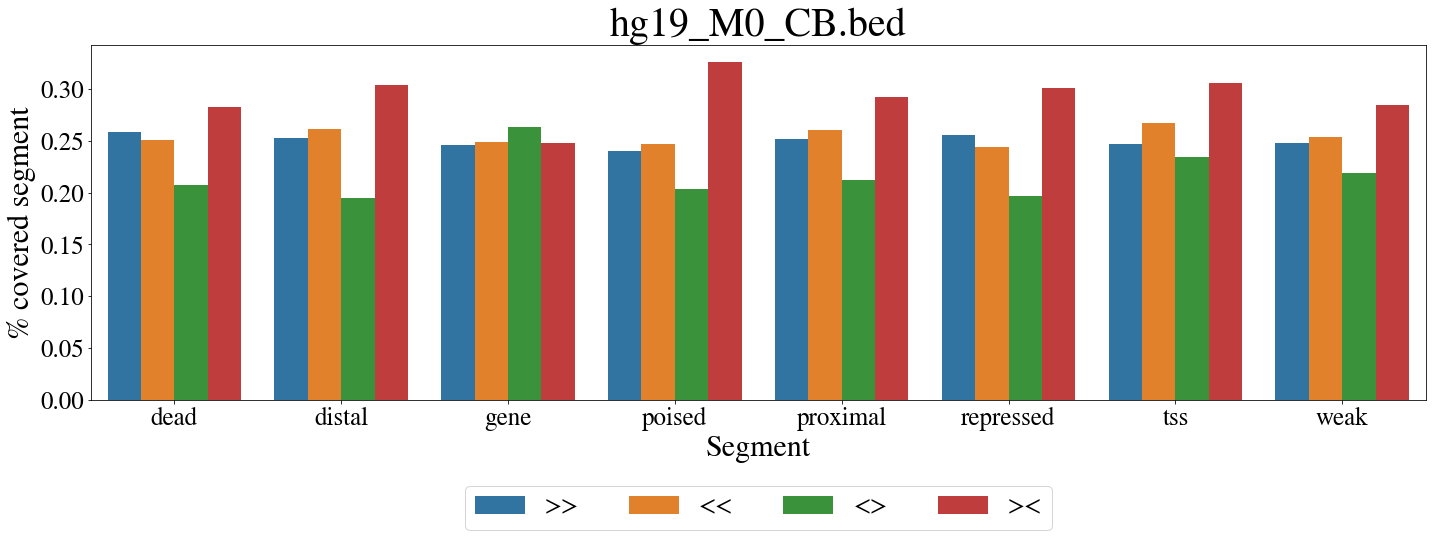

In [58]:
fig = plt.figure(figsize=(20, 8))
sns.barplot(data=segs_biplets, x='name', y='covered_segs', hue='pattern', estimator=sum, ci=None,
            hue_order=['>>', '<<', '<>', '><'], order=sorted(segmentation.name.unique()))
plt.xlabel("Segment", fontsize=30)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.ylabel("% covered segment", fontsize=30)
plt.legend(fontsize=25, ncol=4, loc='lower center', bbox_to_anchor=(0.5, -0.4))
plt.title(str(path).split("/")[-1], fontsize=40)
plt.show()